<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/IEEE/Classification_Pokemon_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [1]:
# import libraries
import os
import datetime
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import files
from google_drive_downloader import GoogleDriveDownloader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%load_ext tensorboard

In [2]:
file_id = "1lKfmEjyovEvvZ2zBUkdJwl2fnF4C5OyM" # pokemon dataset id
folder = "dataset" # main folder

# download data
GoogleDriveDownloader.download_file_from_google_drive(
    file_id = file_id,
    dest_path = "/content/pokemon.zip",
    unzip = True
)


Unzipping...Done.


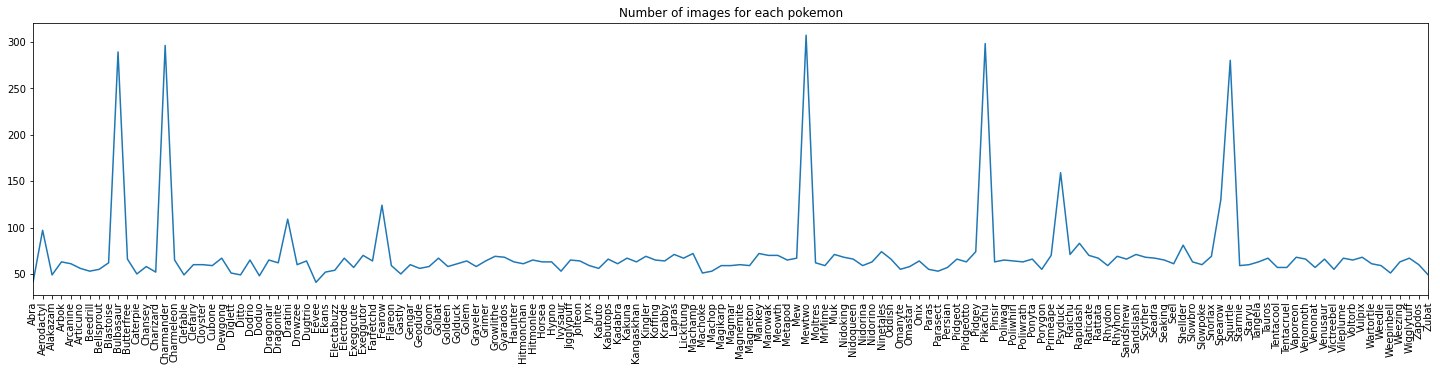

In [3]:
# explore data
pokemon_count = {}
index_weight = {} # class imbalance => class_weight = total_images / class_samples
pokemon_list = os.listdir("/content/{}".format(folder))
pokemon_list.sort() # alphabetical order

for index, pokemon in enumerate(pokemon_list):
    pokemon_count[pokemon] = len(os.listdir("/content/{}/{}".format(folder, pokemon)))
    index_weight[index] = 1 / len(os.listdir("/content/{}/{}".format(folder, pokemon)))

index_weight = {k: v * total for total in (sum(index_weight.values()),) for k, v in index_weight.items()}

fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(pokemon_count.keys()), y = list(pokemon_count.values())).set_title('Number of images for each pokemon')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

# Create data feed

In [4]:
seed = 2
height, width = 224, 224
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.1)

train_data = datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "training"
)

val_data = datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "validation"
)

test_datagen = ImageDataGenerator(
    validation_split = 0.1
)

test_data = test_datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "validation"
)

# get the inverse of class_indices
indices_class = {value: key for key, value in val_data.class_indices.items()}
print(indices_class)


Found 9663 images belonging to 149 classes.
Found 994 images belonging to 149 classes.
Found 994 images belonging to 149 classes.
{0: 'Abra', 1: 'Aerodactyl', 2: 'Alakazam', 3: 'Arbok', 4: 'Arcanine', 5: 'Articuno', 6: 'Beedrill', 7: 'Bellsprout', 8: 'Blastoise', 9: 'Bulbasaur', 10: 'Butterfree', 11: 'Caterpie', 12: 'Chansey', 13: 'Charizard', 14: 'Charmander', 15: 'Charmeleon', 16: 'Clefable', 17: 'Clefairy', 18: 'Cloyster', 19: 'Cubone', 20: 'Dewgong', 21: 'Diglett', 22: 'Ditto', 23: 'Dodrio', 24: 'Doduo', 25: 'Dragonair', 26: 'Dragonite', 27: 'Dratini', 28: 'Drowzee', 29: 'Dugtrio', 30: 'Eevee', 31: 'Ekans', 32: 'Electabuzz', 33: 'Electrode', 34: 'Exeggcute', 35: 'Exeggutor', 36: 'Farfetchd', 37: 'Fearow', 38: 'Flareon', 39: 'Gastly', 40: 'Gengar', 41: 'Geodude', 42: 'Gloom', 43: 'Golbat', 44: 'Goldeen', 45: 'Golduck', 46: 'Golem', 47: 'Graveler', 48: 'Grimer', 49: 'Growlithe', 50: 'Gyarados', 51: 'Haunter', 52: 'Hitmonchan', 53: 'Hitmonlee', 54: 'Horsea', 55: 'Hypno', 56: 'Ivysaur'

# Model Build

## Efficient + Xception + mobile model

In [ ]:
def base_model(shape):
    """
    base_model as a function, create the convolutional layers
    Parameters:
    shape = the shape of the input, tuple (height, width, channels)
    Returns:
    a tensorflow model object
    """
    # make an input layer, with shape equals to the input_shape
    input = tf.keras.layers.Input(shape = shape, name = "input_layer")
    
    # preprocess the input
    efficient_input = tf.keras.applications.efficientnet.preprocess_input(input)
    xception_input = tf.keras.applications.xception.preprocess_input(input)
    mobile_input = tf.keras.applications.mobilenet_v3.preprocess_input(input)

    # instantiate the pre-trained model
    efficient_model = tf.keras.applications.EfficientNetB7(include_top = False, # don't include the Fully Conected Layers
                                                           input_shape = input_shape, 
                                                           pooling = "max", # returns a flatten layer
                                                           weights = "imagenet") 
    
    xception_model = tf.keras.applications.Xception(include_top = False,
                                                    input_shape = input_shape,
                                                    pooling = "max",
                                                    weights = "imagenet")
    
    mobile_model = tf.keras.applications.MobileNetV3Small(include_top = False,
                                                          input_shape = input_shape,
                                                          pooling = "max",
                                                          minimalistic = True,
                                                          weights = "imagenet")
    
    efficient_model.trainable = False # freeze model weights training
    xception_model.trainable = False
    mobile_model.trainable = False

    efficient_output = efficient_model(efficient_input) # feed the each preprocessed image in the right pre-trained model
    xception_output = xception_model(xception_input)
    mobile_output = mobile_model(mobile_input)

    y = tf.keras.layers.Concatenate()([efficient_output, # concatenate the 3 outputs into a single layer
                                       xception_output,
                                       mobile_output])
    
    model = tf.keras.models.Model( # instantiate the tensorflow model with input as the input and y as the output
        inputs = input,
        outputs = y)  
    
    return model

def my_model(n_class):
    model = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 4096, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 1024, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 256, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = n_class, activation = "softmax")
    ])
    return model  

input_shape = (height, width, 3)
n_class = len(train_data.class_indices.keys())

conv_model = base_model(shape = (height,width,3))
fc_model = my_model(n_class = n_class)

model = tf.keras.models.Sequential([conv_model, fc_model])

model.summary()                              

## vgg + resnet + xception model


### VGG-19 (2014)
[paper](https://arxiv.org/abs/1409.1556)

[TensorFlow implementation](https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/applications/vgg19.py#L45-L231)



In [5]:
def block(x, n_convs, filters, block_name, kernel_size = (3, 3), activation = "relu", pool_size = (2, 2), pool_stride = (2, 2)):
  '''
  Defines a block in the VGG network.

  Returns:
    tensor containing the max-pooled output of the convolutions
  '''

  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding = "same", name="{}_conv{}".format(block_name, i + 1),
                                 kernel_initializer = "he_uniform")(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size = pool_size, strides = pool_stride, name = "{}_pool{}".format(block_name, i+1))(x)

  return x

def VGG_19(shape, pool):
    input = tf.keras.layers.Input(shape = shape, name = "input_layer")
    x = input

    x = block(x, n_convs = 2, filters = 64, block_name = "block1")
    x = block(x, n_convs = 2, filters = 128, block_name = "block2")
    x = block(x, n_convs = 4, filters = 256, block_name = "block3")
    x = block(x, n_convs = 4, filters = 512, block_name = "block4")
    x = block(x, n_convs = 4, filters = 512, block_name = "block5")

    if pool == "average":
        y = tf.keras.layers.GlobalAveragePooling2D()(x)
    if pool == "max":
        y = tf.keras.layers.GlobalMaxPooling2D()(x)

    # y = tf.keras.layers.Dense(units = n_class, activation = "softmax", kernel_initializer = "he_uniform")(y)

    model = tf.keras.Model(
        inputs = input,
        outputs = y,
        name = "vgg19_model"
    )
    return model

### ResNet-50 (2015)
[paper](https://arxiv.org/abs/1512.03385)

[TensorFlow implementation](https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/applications/resnet.py#L453-L472)

In [6]:
def res_conv(x, filters, activation = "relu", epsilon = 1.001e-5, strides = (1, 1)):
    x_short = tf.keras.layers.Conv2D(filters = 4 * filters, kernel_size = (1, 1), kernel_initializer = "he_uniform",
                                     strides = strides)(x)
    x_short = tf.keras.layers.BatchNormalization(epsilon = epsilon)(x_short)

    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1, 1), kernel_initializer = "he_uniform",
                               strides = strides)(x)
    x = tf.keras.layers.BatchNormalization(epsilon = epsilon)(x)
    x = tf.keras.layers.Activation(activation = activation)(x)

    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.BatchNormalization(epsilon = epsilon)(x)
    x = tf.keras.layers.Activation(activation = activation)(x)

    x = tf.keras.layers.Conv2D(filters = 4 * filters, kernel_size = (1, 1), kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.BatchNormalization(epsilon = epsilon)(x)

    x = tf.keras.layers.Add()([x, x_short])
    y = tf.keras.layers.Activation(activation = activation)(x)
    return y

def res_id(x, filters, activation = "relu", epsilon = 1.001e-5):
    x_short = x

    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1, 1), kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.BatchNormalization(epsilon = epsilon)(x)
    x = tf.keras.layers.Activation(activation = activation)(x)

    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.BatchNormalization(epsilon = epsilon)(x)
    x = tf.keras.layers.Activation(activation = activation)(x)

    x = tf.keras.layers.Conv2D(filters = 4 * filters, kernel_size = (1, 1), kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.BatchNormalization(epsilon = epsilon)(x)

    x = tf.keras.layers.Add()([x, x_short])
    y = tf.keras.layers.Activation(activation = activation)(x)
    return y

def resnet_50(shape, pool):
    input = tf.keras.layers.Input(shape = shape, name = "input_layer")

    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3)))(input)

    x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), kernel_initializer = "he_uniform",
                               strides = (2, 2))(x)
    x = tf.keras.layers.BatchNormalization(epsilon = 1.001e-5)(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = tf.keras.layers.MaxPooling2D(3, strides = 2)(x)

    x = res_conv(x = x, filters = 64)
    x = res_id(x = x, filters = 64)
    x = res_id(x = x, filters = 64)

    x = res_conv(x = x, filters = 128, strides = (2, 2))
    x = res_id(x = x, filters = 128)
    x = res_id(x = x, filters = 128)
    x = res_id(x = x, filters = 128)

    x = res_conv(x = x, filters = 256, strides = (2, 2))
    x = res_id(x = x, filters = 256)
    x = res_id(x = x, filters = 256)
    x = res_id(x = x, filters = 256)
    x = res_id(x = x, filters = 256)
    x = res_id(x = x, filters = 256)

    x = res_conv(x = x, filters = 512, strides = (2, 2))
    x = res_id(x = x, filters = 512)
    x = res_id(x = x, filters = 512)

    if pool == "average":
        y = tf.keras.layers.GlobalAveragePooling2D()(x)
    if pool == "max":
        y = tf.keras.layers.GlobalMaxPooling2D()(x)

    # y = tf.keras.layers.Dense(units = n_class, activation = "softmax", kernel_initializer = "he_uniform")(y)

    model = tf.keras.Model(
        inputs = input,
        outputs = y,
        name = "resnet_model"
    )

    return model

### Xception (2016)
[paper](https://arxiv.org/abs/1610.02357)

[TensorFlow implementation](https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/applications/xception.py#L50-L315)

In [7]:
def xception_convA(x, filters, activation = "relu"):
    x_short = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1, 1), strides = (2, 2), kernel_initializer = "he_uniform",
                                     padding = "same", use_bias = False)(x)
    x_short = tf.keras.layers.BatchNormalization()(x_short)

    x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = activation)(x)

    x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x) 

    x = tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                                     padding = "same")(x)
    y = tf.keras.layers.Add()([x, x_short])  

    return y

def xception_convB(x, filters, activation = "relu"):
    x_short = x

    x = tf.keras.layers.Activation(activation = activation)(x)
    x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation(activation = activation)(x)
    x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation(activation = activation)(x)
    x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    y = tf.keras.layers.Add()([x, x_short])

    return y

def xception_convC(x, filters, activation = "relu"):
    x_short = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1, 1), strides = (2, 2), kernel_initializer = "he_uniform",
                                     padding = "same", use_bias = False)(x)
    x_short = tf.keras.layers.BatchNormalization()(x_short)

    x = tf.keras.layers.Activation(activation = activation)(x)
    x = tf.keras.layers.SeparableConv2D(filters = 728, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation(activation = activation)(x)
    x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                                     padding = "same")(x)
    y = tf.keras.layers.Add()([x, x_short])  

    return y

def xception(shape, pool):
    input = tf.keras.layers.Input(shape = shape)

    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (2, 2), kernel_initializer = "he_uniform",
                               use_bias = False)(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = "relu")(x)

    x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                               use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = "relu")(x)
    
    x = xception_convA(x = x, filters = 128)
    x = xception_convA(x = x, filters = 256)
    x = xception_convA(x = x, filters = 728)

    x = xception_convB(x = x, filters = 728)
    x = xception_convB(x = x, filters = 728)
    x = xception_convB(x = x, filters = 728)
    x = xception_convB(x = x, filters = 728)
    x = xception_convB(x = x, filters = 728)
    x = xception_convB(x = x, filters = 728)
    x = xception_convB(x = x, filters = 728)
    x = xception_convB(x = x, filters = 728)

    x = xception_convC(x = x, filters = 1024)

    x = tf.keras.layers.SeparableConv2D(filters = 1536, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = "relu")(x)

    x = tf.keras.layers.SeparableConv2D(filters = 2048, kernel_size = (3, 3), kernel_initializer = "he_uniform",
                                        padding = "same", use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation = "relu")(x)

    if pool == "average":
        y = tf.keras.layers.GlobalAveragePooling2D()(x)
    if pool == "max":
        y = tf.keras.layers.GlobalMaxPooling2D()(x)

    model = tf.keras.Model(
        inputs = input,
        outputs = y,
        name = "xception_model"
    )

    return model

### my_model

In [8]:
def my_model(shape):
    input = tf.keras.layers.Input(shape)

    vgg_model = VGG_19(shape = (height,width,3), pool = "max")
    resnet_model = resnet_50(shape = (height,width,3), pool = "max")
    xception_model = xception(shape = (height,width,3), pool = "max")

    vgg_input = tf.keras.applications.vgg19.preprocess_input(input)
    resnet_input = tf.keras.applications.resnet50.preprocess_input(input)
    xception_input = tf.keras.applications.xception.preprocess_input(input)
    
    vgg_out = vgg_model(vgg_input)
    resnet_out = resnet_model(resnet_input)
    xception_out = xception_model(xception_input)

    y = tf.keras.layers.Concatenate(name = "junta_tudo")([vgg_out,
                                                          resnet_out, 
                                                          xception_out])
    model = tf.keras.Model(
        inputs = input,
        outputs = y,
        name = "conv_model"
    )

    return model

def fc_model(n_class):
    model = tf.keras.Sequential([
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.LayerNormalization(),
                                 tf.keras.layers.Dense(units = 2048, activation = "relu"),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.LayerNormalization(),
                                 tf.keras.layers.Dense(units = 512, activation = "relu"),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.LayerNormalization(),
                                 tf.keras.layers.Dense(n_class, activation = "softmax")
    ], name = "fc_model")

    return model


In [9]:
tf.keras.backend.clear_session()
conv_model = my_model(shape = (height,width,3))

n_class = len(indices_class)
model = tf.keras.Sequential([conv_model,
                             fc_model(n_class = n_class)
], name = "my_model")
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_model (Functional)      (None, 4608)              64473576  
_________________________________________________________________
fc_model (Sequential)        (None, 149)               10579093  
Total params: 75,052,669
Trainable params: 74,945,021
Non-trainable params: 107,648
_________________________________________________________________


In [10]:
tf.keras.utils.plot_model(model, show_shapes = True, expand_nested = True)


# train the model

In [11]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(
        tf.keras.optimizers.schedules.ExponentialDecay( # after 6000 steps, the learning rate is updated to half the initial value
            initial_learning_rate = 0.0004, decay_steps = 6000, decay_rate = 0.5 # this number is a hyperparameter, so adjust accordingly
    )),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

history = model.fit(train_data,
                    validation_data = val_data,
                    epochs = 100,
                    callbacks = [tensorboard_callback, callback],
                    class_weight = index_weight # apply the class_weight
                    )

In [ ]:
%tensorboard --logdir logs


# Visualize predits

In [ ]:
images, labels = test_data.next() # get the next batch of test data
predicts = model.predict(images) # get the predictions

n_rows = (len(images) // 4) + 1
plt.figure(figsize = (12,n_rows * 4))

for index, image in enumerate(images):
    plt.subplot(n_rows, 4, index + 1)
    image = np.asarray(image, dtype = np.uint8)
    plt.imshow(image)
    plt.title("real: {}\n predict:{}\n score:{:.3f}".format(
        indices_class[np.argmax(labels[index])], 
        indices_class[np.argmax(predicts[index])],
        np.max(predicts[index])
    ))